In [3]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
import random
from statistics import mean, variance
# from statsmodels.tsa.arima_model import ARIMA
from pathlib import Path


<b>Functions' definitons</b>

In [4]:
def rms(sample): 
	return sqrt(sum([x**2 for x in sample]))

def energy(sample):
	return rms(sample)/sqrt(len(sample))

def cross_cor(sample1,sample2): #The returned vector has len(sample1)+len(sample2)-1
	return np.correlate(sample1,sample2,"full")

def auto_cor(sample): #Here, it is len(sample)
	res=np.correlate(sample,sample,"full")
	return res[len(sample)-1:]
	

def extr(sample): 
	mn=abs(min(sample))
	mx=max(sample)
	if mn>mx:
		return mn
	else:
		return mx
    
def approx_entropy(sample,m,r): #Apparently very useful parameter to measure randomness of data, however calculating it
                                #for data of length>1000 (i.e. for a single vector of len>1000) takes very long time. 
                                #Check https://en.wikipedia.org/wiki/Approximate_entropy
    def maxdist(x_i, x_j):
        return max(abs(np.subtract(x_i,x_j)))

    def phi(m):

        x = [[sample[j] for j in range(i, i + m)] for i in range(N - m + 1)]

        C = [len([1 for x_j in x if maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]

        print('here')

        return sum(np.log(C))/(N - m + 1.0)

    N = len(sample)

    return abs(phi(m+1) - phi(m))

def ARIMA_fit(sample,p,d,q):  #Fitting to model https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model
                              #Fitting takes a lot of time, and it is not obvious what parameters (p,d,q) to use. (5,0,1)
                              #worked for me for most data, not for all. There seems to be some weak correlation between
                              #2, maybe 3, of the 6 fitted parameters and time to event.
	model=ARIMA(sample,order=(p,d,q))
	fit=model.fit(disp=0)
	return fit.arparams,fit.maparams

def flatten_cor(data,window=10): #Function to normalize auto- and cross-correlation
	
	temp=[0]*len(data)
	for i in range(len(data)):
		temp[i]=data[i]-mean(data[max(0,int(i-window/2)):min(len(data),int(i+window/2))])
	return temp

def file_to_list(filename):

	infile=open(filename,'r')
	result=[]
	time=0

	i=1

	for line in infile:

		if line.strip('\n').split() and i<=150000:
			result.append(float(line.split()[0]))
		else:
			time=float(line.split()[0])

		i+=1


	infile.close()	
	return result,time



base_dir="./samples/"

<b>Loading data (75 random samples)</b>

In [19]:
file_numbers=random.sample(range(10000),50)

N=len(file_numbers)

files=[0]*N
T=[0]*N
for i in range(N):
    
	filename=Path(base_dir+"sample"+str(file_numbers[i])+".txt")
	res,t=file_to_list(filename)
	files[i]=res
	T[i]=t

<b>A couple parameters and their correlations:</b>

<b>"Energy"</b>

<IPython.core.display.Javascript object>


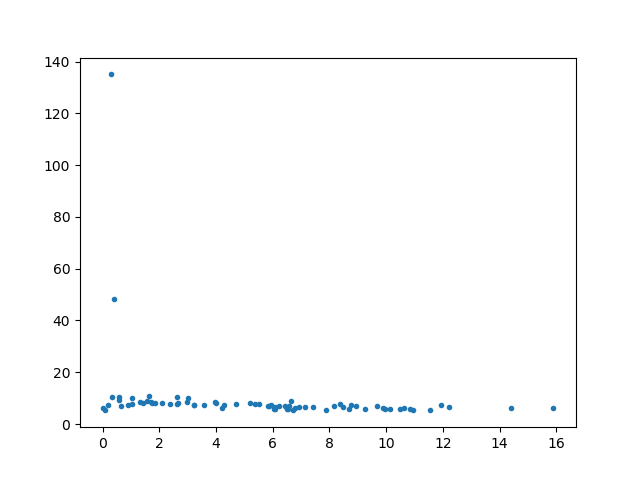

In [14]:
En=[]
for i in range(N):
    En.append(energy(files[i]))
    
# %matplotlib notebook
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(T,En,'.')



<b>Extremum</b>

Text(0.5, 1.0, 'Extr vs En')

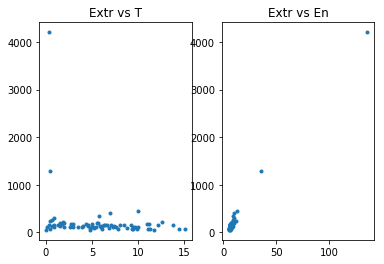

In [18]:
Ex=[]
for i in range(N):
    Ex.append(extr(files[i]))
    
# %matplotlib notebook
fig2=plt.figure()
ax2=fig2.add_subplot(121)
ax2.plot(T,Ex,'.')
ax2.set_title("Extr vs T")

ax22=fig2.add_subplot(122)
ax22.plot(En,Ex,'.')
ax22.set_title("Extr vs En")

Seem quite related to one another...

<b>Autocorrelation.</b> First, an example:

Text(0.5, 1.0, 'Flattened autocorrelation')

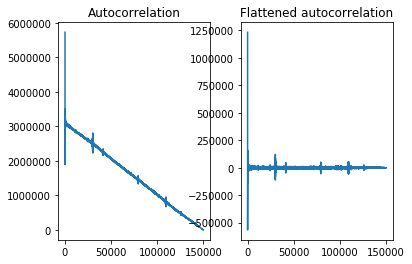

In [20]:
acr_example=auto_cor(files[0])
acr_ex_flat=flatten_cor(acr_example)


fig3=plt.figure()
ax3=fig3.add_subplot(121)
ax3.plot(acr_example)
ax3.set_title("Autocorrelation")

ax33=fig3.add_subplot(122)
ax33.plot(acr_ex_flat)
ax33.set_title("Flattened autocorrelation")

Now, relationship with time to event of the fifth component (so sumed x(i) * x(i-5) in the vector) and "energy" of autocorrelation. (Calculation might take some time) 

Text(0.5, 1.0, 'En of Autocorr vs En')

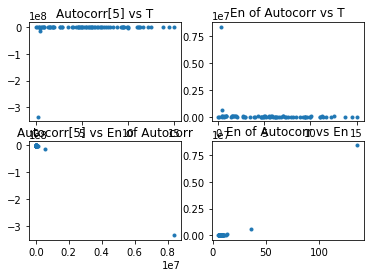

In [22]:
ACR=[]
EnACR=[]

for i in range(N):
    ac=flatten_cor(auto_cor(files[i]))
    ACR.append(ac[5]/len(ac))
    EnACR.append(energy(ac))
    


<IPython.core.display.Javascript object>


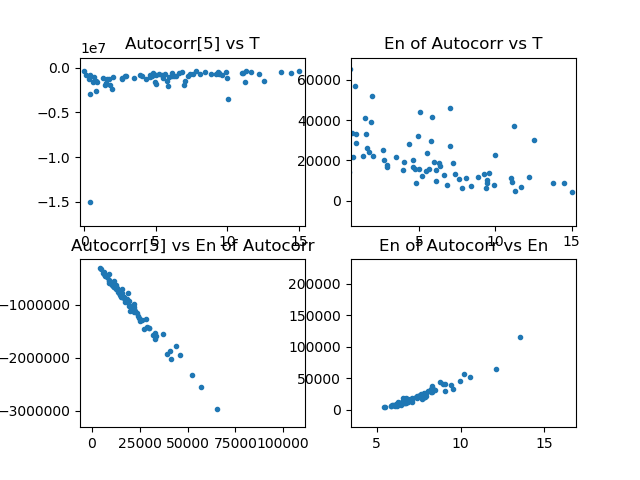

Text(0.5, 1.0, 'En of Autocorr vs En')

In [23]:
%matplotlib notebook
fig4=plt.figure()
ax4=fig4.add_subplot(221)
ax4.plot(T,ACR,'.')
ax4.set_title("Autocorr[5] vs T")

ax42=fig4.add_subplot(222)
ax42.plot(T,EnACR,'.')
ax42.set_title("En of Autocorr vs T")

ax43=fig4.add_subplot(223)
ax43.plot(EnACR,ACR,'.')
ax43.set_title("Autocorr[5] vs En of Autocorr")

ax44=fig4.add_subplot(224)
ax44.plot(En,EnACR,'.')
ax44.set_title("En of Autocorr vs En")

To no surprise, these parameters seem close related to one another, and to the previous parameter, although the last relationship seems quadratic.

<b>FFT</b>

First, a look at a sample FFT:

Text(0.5, 1.0, 'FFT')

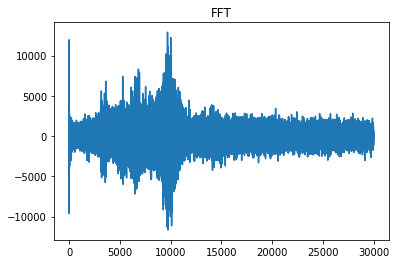

In [11]:
fft_example=np.fft.rfft(files[0])
fft_example.real[0]=0
fft_example=fft_example.real[:int(2*len(fft_example)/5)]


fig5=plt.figure()
ax5=fig5.add_subplot(111)
ax5.plot(fft_example)
ax5.set_title("FFT")

Correlations of poweres of different blocks of the FFT with time to event:

<IPython.core.display.Javascript object>


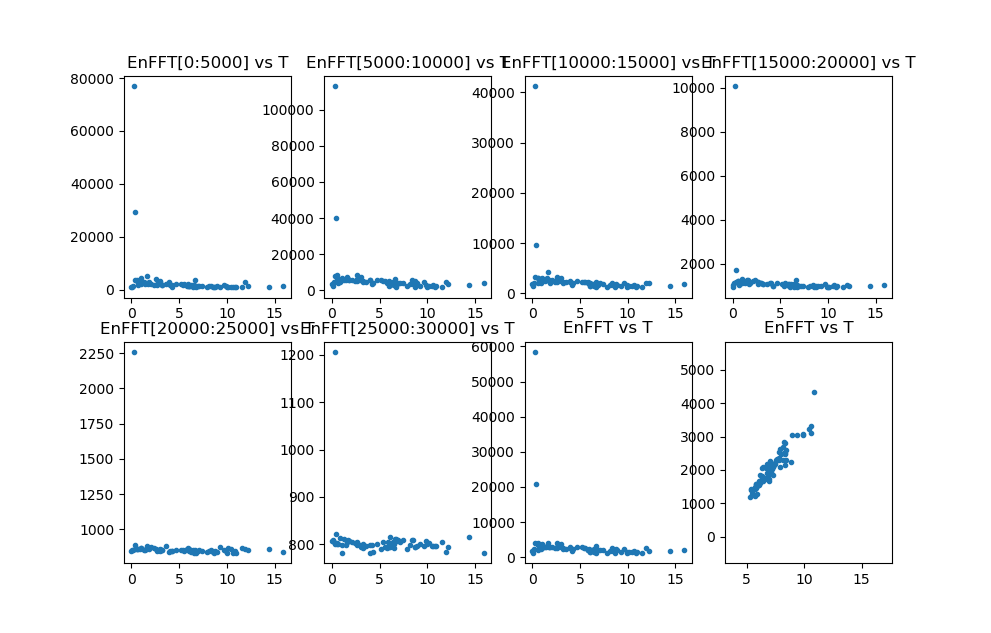

Text(0.5, 1.0, 'EnFFT vs T')

In [15]:
F1=[]
F2=[]
F3=[]
F4=[]
F5=[]
F6=[]
F=[]

for i in range(N):
    fft_res=np.fft.rfft(files[i])
    fft_res.real[0]=0
    fft_res=fft_res.real[:int(2*len(fft_res)/5)]
    
    F1.append(energy(fft_res[:int(len(fft_res)/6)]))
    F2.append(energy(fft_res[int(len(fft_res)/6):int(2*len(fft_res)/6)]))
    F3.append(energy(fft_res[int(2*len(fft_res)/6):int(3*len(fft_res)/6)]))
    F4.append(energy(fft_res[int(3*len(fft_res)/6):int(4*len(fft_res)/6)]))
    F5.append(energy(fft_res[int(4*len(fft_res)/6):int(5*len(fft_res)/6)]))
    F6.append(energy(fft_res[int(5*len(fft_res)/6):]))
    F.append(energy(fft_res))

%matplotlib notebook
fig6=plt.figure()
ax6=fig6.add_subplot(241)
ax6.plot(T,F1,'.')
ax6.set_title("EnFFT[0:5k] vs T")

ax62=fig6.add_subplot(242)
ax62.plot(T,F2,'.')
ax62.set_title("EnFFT[5k:10k] vs T")

ax63=fig6.add_subplot(243)
ax63.plot(T,F3,'.')
ax63.set_title("EnFFT[10k:15k] vs T")

ax64=fig6.add_subplot(244)
ax64.plot(T,F4,'.')
ax64.set_title("EnFFT[15k:20k] vs T")

ax65=fig6.add_subplot(245)
ax65.plot(T,F5,'.')
ax65.set_title("EnFFT[20k:25k] vs T")

ax66=fig6.add_subplot(246)
ax66.plot(T,F6,'.')
ax66.set_title("EnFFT[25k:30k] vs T")

ax67=fig6.add_subplot(247)
ax67.plot(T,F,'.')
ax67.set_title("EnFFT vs T")

ax67=fig6.add_subplot(248)
ax67.plot(En,F3,'.')
ax67.set_title("EnFFT vs En")



It seems that the best prediction can be obtained from frequencies between 5000 and 20000.

One can also play with FFTs of autocorrelation or autocorrelation of FFT, but the results will be very similar to the ones above. I found that for example "energy" of FFT of autocorrelation is a paramter reasonably well correlated with time to the event.

<b>Cross-correlation</b>

Almost done


<IPython.core.display.Javascript object>


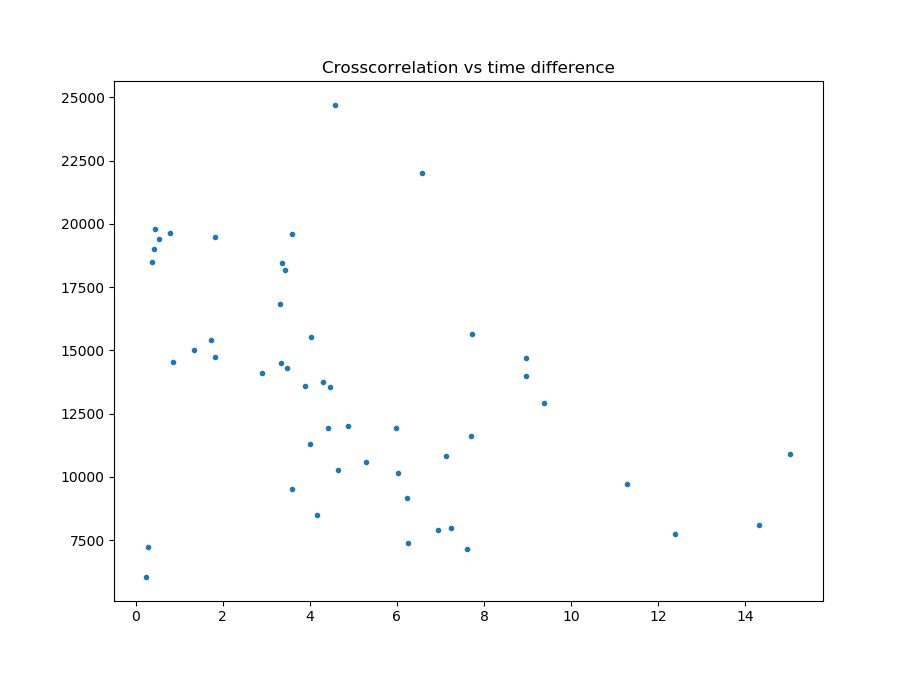

Text(0.5, 1.0, 'Crosscorrelation vs time difference')

In [20]:
base_vector=files[0]
CCR=[]
Tccr=[]
for i in range(1,N):
    
    CCR.append(energy(flatten_cor(cross_cor(base_vector,files[i]))))
    Tccr.append(abs(T[0]-T[i]))
    if N-i==10:
        print("Almost done")
    
fig7=plt.figure()
ax7=fig7.add_subplot(111)
ax7.plot(Tccr,CCR,'.')
ax7.set_title("Crosscorrelation vs time difference")